In [ ]:
!unzip knight_data.zip

Archive:  knight_data.zip
 extracting: knight_data/no_knight.zip  
   creating: knight_data/no_knight/
  inflating: knight_data/no_knight/000_S__8699934_mirror.jpg  
  inflating: knight_data/no_knight/000_S__8699934_resized.jpg  
  inflating: knight_data/no_knight/001_S__8699935_mirror.jpg  
  inflating: knight_data/no_knight/001_S__8699935_resized.jpg  
  inflating: knight_data/no_knight/002_S__8699936_mirror.jpg  
  inflating: knight_data/no_knight/002_S__8699936_resized.jpg  
  inflating: knight_data/no_knight/003_S__8699937_mirror.jpg  
  inflating: knight_data/no_knight/003_S__8699937_resized.jpg  
  inflating: knight_data/no_knight/004_S__8699938_mirror.jpg  
  inflating: knight_data/no_knight/004_S__8699938_resized.jpg  
  inflating: knight_data/no_knight/005_S__8699967_mirror.jpg  
  inflating: knight_data/no_knight/005_S__8699967_resized.jpg  
  inflating: knight_data/no_knight/006_S__8699968_mirror.jpg  
  inflating: knight_data/no_knight/006_S__8699968_resized.jpg  
  inflat

In [ ]:
import keras
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.utils import plot_model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import time
import sys
import cv2

2021年　1月3日
私は、「クラッシュロワイアル」というタワーディフェンスゲームで、相手陣地の中に
「knight」というキャラが存在するかについてCNNを使って判別しました。

工夫した点は画像処理の部分です。
相手陣地のみを抜き出すこと、CNNの構造上正方形の画像にするため、それらを構築することに時間がかかりました。
画像の切り取りをして、正方形になるように短い辺を黒い背景で埋めました。
CNNの構造についてはなかなかオルジナル画像について判別したサイトがなかなか見つからず時間がかかりました。
https://child-programmer.com/download/cnn-originaldataset-samplecode-description-pdf/
こちらのオルジナルデータセット対応の機械学習サンプルコードを参考にしながら進め、エポック数やバッチ数を調整し構築しました。

結果については、最初は50%前後でした。これは画像サイズがとても低い状態で行っていたので、判別が難しかったことが原因で、画像サイズを上げると、70%まで上げることができました。
そこからは、エポック数やバッチ数を変動しましたが、80%以上上げることがなかなかできませんでした。これは、画像の数が少ないことが原因として考えられます。
ゲーム画面のデータをウェブサイトにあまり乗っておらず、自分でスクリーンショットを利用して集めたため、100枚ずつしか集めることができませんでした。反転した画像もフォルダに入れましたが、データ拡張はほかにもできたと感じています。


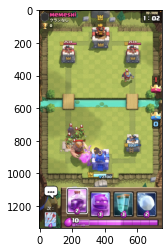

In [ ]:
orig = cv2.imread('yes_knight.jpg')
src = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
plt.imshow(src)
#クラッシュロワイアルのゲーム画面、相手陣地が真ん中より上の画面。(500,400)あたりにいるキャラがknightというキャラ。今回は相手陣地にknightがいるかどうか、yes_knight,no_knightの二つに分けて判別を行っていく。

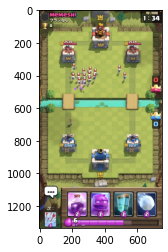

In [ ]:
orig = cv2.imread('no_knight.jpg')
src = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
plt.imshow(src)
#こちらの画像には、 knightがいない。ほかのキャラが入っているので、それらの判別ををする。

In [ ]:
##自分の陣地、周りの枠の部分は必要ないのでboxサイズに合わせて敵陣地のみを取り出す###
box = (45, 80, 700, 550)
files = glob.glob('./Documents/yes_knight/*.jpg')
for f in files:
    img = Image.open(f)
    img_resize = expand2square(img.crop(box), (0, 0, 0)).resize((thumb_width, thumb_width), Image.LANCZOS)
    title, ext = os.path.splitext(f)
    img_resize.save(title + '_resized' + ext)

In [ ]:
##横長になってしまったので、正方形にするため縦方向に背景黒で埋める###
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

In [ ]:
#反転した画像も、データ量も増えるので作成し、保存する
for f in files:
    img = Image.open(f)
    img_resize = expand2square(img.crop(box), (0, 0, 0)).resize((thumb_width, thumb_width), Image.LANCZOS)
    im_mirror = ImageOps.mirror(img_resize)
    title, ext = os.path.splitext(f)
    img_resize.save(title + '_mirror' + ext)

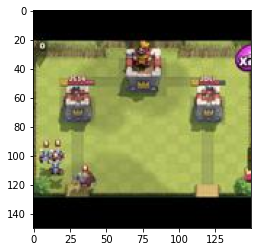

In [ ]:
orig = cv2.imread('knight_data/yes_knight/000_S__8749137_resized.jpg')
src = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
plt.imshow(src)
#これがサイズ変換した後の画像。このような画像をそれぞれのフォルダにわけて判別していく。

In [ ]:
#kerasのimportがanacondaでエラーが発生しできなかったのでここからColaboratoryを利用
train_data_path = "./knight_data"
image_size = 300 #画像サイズの設定

 
color_setting = 3#ここを変更。データセット画像のカラー：「1」はモノクロ・グレースケール。「3」はカラー。

folder = ['yes_knight', 'no_knight'] # ここを変更。データセット画像のフォルダ名（クラス名）を半角英数で入力

class_number = len(folder)
print('今回のデータで分類するクラス数は「', str(class_number), '」です。')


今回のデータで分類するクラス数は「 2 」です。


In [ ]:

#3 データセットの読み込みとデータ形式の設定・正規化・分割
X_image = []
Y_label = []

In [ ]:
for index, name in enumerate(folder):
    read_data = train_data_path + '/' + name
    files = glob.glob(read_data + '/*') 
    print('--- 読み込んだデータセットは', read_data, 'です。')
    for i, file in enumerate(files):
        if color_setting == 1:
            img = load_img(file, color_mode = 'grayscale' ,target_size=(image_size, image_size))
        elif color_setting == 3:
            img = load_img(file, color_mode = 'rgb' ,target_size=(image_size, image_size))
        array = img_to_array(img)
        X_image.append(array)
        Y_label.append(index)

--- 読み込んだデータセットは ./knight_data/yes_knight です。
--- 読み込んだデータセットは ./knight_data/no_knight です。


In [ ]:
X_image = np.array(X_image)
Y_label = np.array(Y_label)

X_image = X_image.astype('float32') / 255
Y_label = keras.utils.to_categorical(Y_label, class_number)

train_images, valid_images, train_labels, valid_labels = train_test_split(X_image, Y_label, test_size=0.10)
x_train = train_images
y_train = train_labels
x_test = valid_images
y_test = valid_labels

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 150, 150, 128)     18560     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 150, 150, 256)     295168    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 256)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 75, 75, 256)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1440000)          

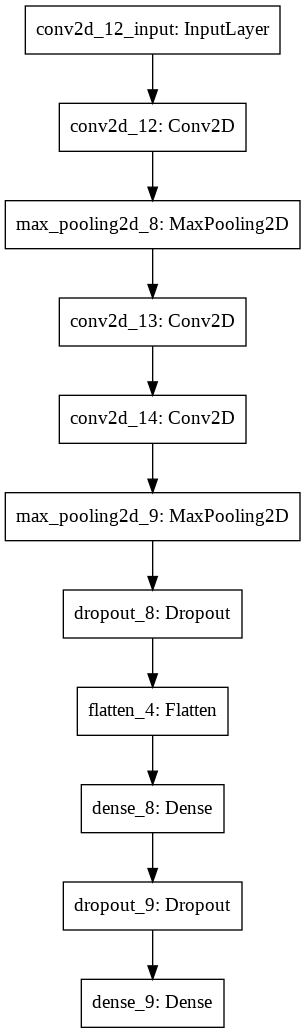

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same',
input_shape=(image_size, image_size, color_setting), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(class_number, activation='softmax'))

model.summary()
plot_model(model, to_file='model.png')

In [ ]:
model.compile(loss='categorical_crossentropy',
optimizer=Adam(),
metrics=['accuracy'])

start_time = time.time()

history = model.fit(x_train,y_train, batch_size=8, epochs=5, verbose=1,validation_data=(x_test, y_test))

Epoch 1/5
23/23 [==============================] - 160s 7s/step - loss: 0.6732 - accuracy: 0.5599 - val_loss: 0.5840 - val_accuracy: 0.7000
Epoch 2/5
23/23 [==============================] - 159s 7s/step - loss: 0.5274 - accuracy: 0.7652 - val_loss: 0.4105 - val_accuracy: 0.9000
Epoch 3/5
23/23 [==============================] - 158s 7s/step - loss: 0.4026 - accuracy: 0.7989 - val_loss: 0.4495 - val_accuracy: 0.7500
Epoch 4/5
23/23 [==============================] - 158s 7s/step - loss: 0.3929 - accuracy: 0.8214 - val_loss: 0.4473 - val_accuracy: 0.8000
Epoch 5/5
23/23 [==============================] - 157s 7s/step - loss: 0.2184 - accuracy: 0.9290 - val_loss: 0.3543 - val_accuracy: 0.8500


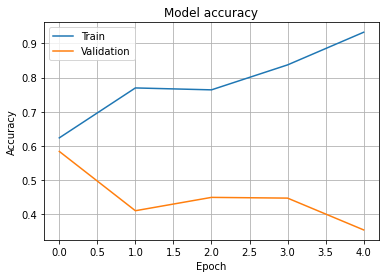

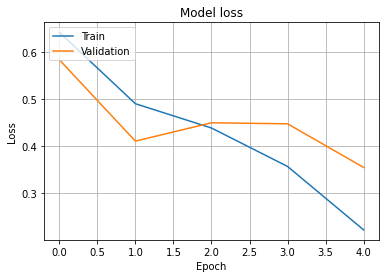

Loss: 0.35431107878685 （損失関数値 - 0に近いほど正解に近い）
Accuracy: 85.00000238418579 % （精度 - 100% に近いほど正解に近い）
Computation time（計算時間）:827.646 sec（秒）


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

open('cnn_model.json','w').write(model.to_json())
model.save_weights('cnn_weights.h5')
score = model.evaluate(x_test, y_test, verbose=0)
print('Loss:', score[0], '（損失関数値 - 0に近いほど正解に近い）')
print('Accuracy:', score[1] * 100, '%', '（精度 - 100% に近いほど正解に近い）')
print('Computation time（計算時間）:{0:.3f} sec（秒）'.format(time.time() - start_time))